In [2]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

import math

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

%load_ext autoreload
%autoreload 2

class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. G=2, N=4 (N_1=2, N_2=2), K=4 (K_1=2, K_2=2)

In [28]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 4 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [29]:
G = 2
N = 4 # N should be divisible by G
K = 4 # N should be divisible by G

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

In [30]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_G2 = np.zeros((N_trials,N_epochs))
acc_test_arr_G2  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_G2[trial_idx][iter] = acc_test
        loss_test_arr_G2[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2973 
Accuracy: 2163/10000 (21.63%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2949 
Accuracy: 1899/10000 (18.99%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.8496 
Accuracy: 7254/10000 (72.54%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.3448 
Accuracy: 9530/10000 (95.30%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.3019 
Accuracy: 9539/10000 (95.39%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.2349 
Accuracy: 9617/10000 (96.17%)

selected users: 

In [13]:
print(np.shape(X_group[G_idx,:,:]))

(30000, 784)


# 2. G=3, K=6 (K_i=2), N=6 (N_i=6)

In [21]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 6 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [22]:
G = 3
N = 6 # N should be divisible by G
K = 6 # N should be divisible by G

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

In [24]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N_i = int(N/G)
K_i = int(K/G)
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_G3 = np.zeros((N_trials,N_epochs))
acc_test_arr_G3  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_G3[trial_idx][iter] = acc_test
        loss_test_arr_G3[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

@BACC_Enc: N,K,T, m_i= 2 2 3 10000 

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 1027/10000 (10.27%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2964 
Accuracy: 2574/10000 (25.74%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2028 
Accuracy: 5098/10000 (50.98%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.4135 
Accuracy: 6138/10000 (61.38%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.8341 
Accuracy: 8016/10000 (80.16%)

selected users: [0 1]
selected users: [0 1]
se

# 3. K=2, Without Grouping

In [19]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 2 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [20]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2,4,6,8]
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_v1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_v1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)

        if N==2:
            z_array = np.array([-0.81, 0.81])
        elif N ==4:
            z_array = np.array([-0.81, -0.22, 0.22, 0.81])
        elif N ==5:
            z_array = np.array([-0.81, -0.22, 0, 0.22, 0.81])
        elif N ==6:
            z_array = np.array([-0.9, -0.81, -0.22, 0.22, 0.81, 0.9])
        elif N ==7:
            z_array = np.array([-0.9, -0.82, -0.21, 0, 0.21, 0.82, 0.9])
        else:
            z_array = np.array([-0.9, -0.81, -0.22, -0.16, 0.16, 0.22, 0.81, 0.9])
#             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((30000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_v1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_v1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [-0.81  0.81]
0.4838626198316927
0.48386261983169315
@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

@BACC_Enc: N,K,T, m_i= 2 2 3 30000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.1504 
Accuracy: 5550/10000 (55.50%)

Round   0, Average loss 2.150 Test accuracy 55.500
selected users: [0 1]

Test set: Average loss: 0.7712 
Accuracy: 8177/10000 (81.77%)

Round   1, Average loss 0.771 Test accuracy 81.770
selected users: [0 1]

Test set: Average loss: 0.2180 
Accuracy: 9692/10000 (96.92%)

Round   2, Average loss 0.218 Test accuracy 96.920
selected users: [0 1]

Test set: Average loss: 0.1758 
Accuracy: 9740/10000 (97.40%)

Round   3, Average loss 0.176 Test accuracy 97.400
selected users: [0 1]

Test set: Average loss: 0.1905 
Accuracy: 9728/10000 (97.28%)

Round   4, Average loss 0.191 Test accuracy 97.280
selected users: [0 1]

Test set: Average loss: 0.1868 
Accuracy: 9750/10000 (97.50%)

Round   5, Average loss 0.187 Test accuracy 97.500
selected 


Test set: Average loss: 1.9353 
Accuracy: 9652/10000 (96.52%)

Round  27, Average loss 1.935 Test accuracy 96.520
selected users: [0 1 2 3]

Test set: Average loss: 1.7971 
Accuracy: 9755/10000 (97.55%)

Round  28, Average loss 1.797 Test accuracy 97.550
selected users: [0 1 2 3]

Test set: Average loss: 1.9200 
Accuracy: 9682/10000 (96.82%)

Round  29, Average loss 1.920 Test accuracy 96.820
z_array: [-0.9  -0.81 -0.22  0.22  0.81  0.9 ]
0.039572349708934106
0.4838626198316927
0.46852880899669475
0.468528808996694
0.48386261983169315
0.039572349708934106
@BACC_Enc: N,K,T, m_i= 6 2 3 30000 

@BACC_Enc: N,K,T, m_i= 6 2 3 30000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5]

Test set: Average loss: 2.2223 
Accuracy: 6257/10000 (62.57%)

Round   1, Average loss 2.222 Test accuracy 62.570
selected users: [0 1 2 3 4 5]

Test set: Av


Test set: Average loss: 0.5977 
Accuracy: 9224/10000 (92.24%)

Round  19, Average loss 0.598 Test accuracy 92.240
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.3295 
Accuracy: 9644/10000 (96.44%)

Round  20, Average loss 0.330 Test accuracy 96.440
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.3735 
Accuracy: 9571/10000 (95.71%)

Round  21, Average loss 0.373 Test accuracy 95.710
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.3915 
Accuracy: 9354/10000 (93.54%)

Round  22, Average loss 0.391 Test accuracy 93.540
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.4134 
Accuracy: 9209/10000 (92.09%)

Round  23, Average loss 0.413 Test accuracy 92.090
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.4039 
Accuracy: 9634/10000 (96.34%)

Round  24, Average loss 0.404 Test accuracy 96.340
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 0.4398 
Accuracy: 9725/10000 (97.25%)

Round  25, Average loss 0.440 Test accurac

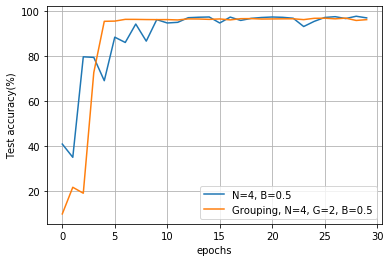

In [35]:
B_sel = 0

# plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_v1[1,B_sel,0,0:30],label='N=4, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_G2[0,0:30],label='Grouping, N=4, G=2, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_G3[0,0:30],label='Grouping, N=6, G=3, B='+str(B_array[B_sel]))

# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 4. K=4

In [10]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 4 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


395 137 77 66 325


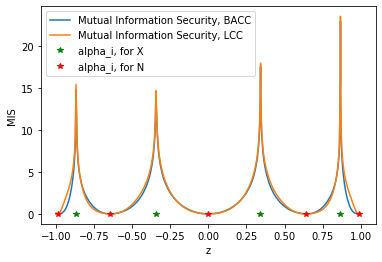

-0.9967233991100619 0.012570500902590362
-0.9948458393310273 0.009186154041335111
-0.9903708272549521 0.0030278602507773783
-0.9881497879818113 0.0011322378640799269
-0.9856357664431257 7.237229030193549e-05
-0.9819502816066774 0.0009151342222115455
-0.9743801406025652 0.013807862953069145
-0.9732429036029051 0.017308391808860374
-0.9716499425996106 0.02300816009848999
-0.9707810034884226 0.026529720146499475
-0.9629358119852338 0.07356572119174355
-0.9592848094889013 0.10648755223399524
-0.9578307990518302 0.12188755258432364
-0.9571486494917996 0.12959372414089768
-0.9548728694739659 0.15764285382604115
-0.9543836651467361 0.16416119397904505
-0.9512302584551071 0.21060896428961837
-0.9501286871582235 0.22873571263139653
-0.9493079992209263 0.24291445045342466
-0.9468712143720244 0.2885550929930391
-0.9462045027048012 0.3020009958277021
-0.9450226360856129 0.3268894006886918
-0.942889051744954 0.37535344112475444
-0.9420255449368415 0.3963084326299616
-0.9399882819365448 0.4489394665

-0.05391121245331343 0.08429198796341066
-0.05116035452277945 0.07578293577457994
-0.04994750389353486 0.07218121551212613
-0.047126382974370884 0.06415583985005885
-0.046510482267415165 0.06246897693064006
-0.045224290722228 0.059021297802406635
-0.04302562861680004 0.05336170018208458
-0.04279176091843295 0.052777010177149704
-0.042151974953842375 0.05119444792253114
-0.0419389393921108 0.05067299418835479
-0.037184159104619585 0.03974693693077096
-0.03599721971014902 0.03723101295809522
-0.034571804105439696 0.03432061510526045
-0.032943207737284874 0.03114315714139796
-0.02942909211734679 0.02482133992077939
-0.02763593275015186 0.021875507639314232
-0.0229133855453163 0.015016784374369168
-0.02193911643328339 0.013763363491504177
-0.020419263130643017 0.011917939772911697
-0.01960321250414343 0.010982258618801446
-0.018245328503861957 0.009510612438407
-0.01776810438720222 0.009018683061269081
-0.0156854533165125 0.007025478286782084
-0.013339936301562716 0.005079418947050514
-0.0

In [5]:
K = 4
T = 5
Noise_Alloc = [0,2,4,6,8]
sigma = 1

N = 10

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 1000
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [8]:
z_array_ = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
MIS_array_ = np.zeros(len(z_array_))
for j in range(len(z_array_)):
    MIS_array_[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array_[j]], 1,sigma)

print(MIS_array_)


[0.44862362 0.49983047 0.4896348  0.48571877 0.48571877 0.4896348
 0.49983047 0.44862362]


In [52]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 5
sigma = 1
Noise_Alloc = [0,2,4,6,8]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [4, 4, 4, 8]
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_K4_G1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K4_G1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx,'!!!')
        if N_idx==0:
            z_array = np.array([-0.94,-0.534,0.534, 0.94])
        elif N_idx==1:
            z_array = np.array([-0.94, -0.73, 0.73, 0.94])
        elif N_idx==2:
            z_array = np.array([-0.94, -0.125, 0.125, 0.94])
        else:
            z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
#             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0 !!!
z_array: [-0.94  -0.534  0.534  0.94 ]
0.4486236179368535
0.48963480280841937
0.4896348028084205
0.4486236179368556
@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

(T, sigma)= 5 1 )  0 -th Trial!!
selected users: [0 1 2 3]

Test set: Average loss: 2.1096 
Accuracy: 5721/10000 (57.21%)

Round   0, Average loss 2.110 Test accuracy 57.210
selected users: [0 1 2 3]

Test set: Average loss: 1.1266 
Accuracy: 7100/10000 (71.00%)

Round   1, Average loss 1.127 Test accuracy 71.000
selected users: [0 1 2 3]

Test set: Average loss: 0.5521 
Accuracy: 8830/10000 (88.30%)

Round   2, Average loss 0.552 Test accuracy 88.300
selected users: [0 1 2 3]

Test set: Average loss: 0.5766 
Accuracy: 8792/10000 (87.92%)

Round   3, Average loss 0.577 Test accuracy 87.920
selected users: [0 1 2 3]

Test set: Average loss: 0.5347 
Accuracy: 8754/10000 (87.54%)

Round   4, Average loss 0.535 Test accuracy 87.540
selected users: [0 1 2 3]

Test set: Average loss: 0.4962 
Accurac


Test set: Average loss: 1.9437 
Accuracy: 4549/10000 (45.49%)

Round  25, Average loss 1.944 Test accuracy 45.490
selected users: [0 1 2 3]

Test set: Average loss: 1.9621 
Accuracy: 4538/10000 (45.38%)

Round  26, Average loss 1.962 Test accuracy 45.380
selected users: [0 1 2 3]

Test set: Average loss: 1.5629 
Accuracy: 5165/10000 (51.65%)

Round  27, Average loss 1.563 Test accuracy 51.650
selected users: [0 1 2 3]

Test set: Average loss: 1.5378 
Accuracy: 4532/10000 (45.32%)

Round  28, Average loss 1.538 Test accuracy 45.320
selected users: [0 1 2 3]

Test set: Average loss: 1.7706 
Accuracy: 3791/10000 (37.91%)

Round  29, Average loss 1.771 Test accuracy 37.910
2 !!!
z_array: [-0.94  -0.125  0.125  0.94 ]
0.4486236179368535
0.4857187736123886
0.48571877361238697
0.4486236179368556
@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

(T, sigma)= 5 1 )  0 -th Trial!!
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 1009/10000 (10.09%)

Ro


Test set: Average loss: 1.8736 
Accuracy: 9199/10000 (91.99%)

Round  19, Average loss 1.874 Test accuracy 91.990
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.9324 
Accuracy: 9358/10000 (93.58%)

Round  20, Average loss 1.932 Test accuracy 93.580
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8969 
Accuracy: 9094/10000 (90.94%)

Round  21, Average loss 1.897 Test accuracy 90.940
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8659 
Accuracy: 9164/10000 (91.64%)

Round  22, Average loss 1.866 Test accuracy 91.640
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8866 
Accuracy: 8781/10000 (87.81%)

Round  23, Average loss 1.887 Test accuracy 87.810
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8758 
Accuracy: 9261/10000 (92.61%)

Round  24, Average loss 1.876 Test accuracy 92.610
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.8242 
Accuracy: 9403/10000 (94.03%)

Round  25, Average loss 1.824 Test accurac

## 4.2. With Grouping, N=4, N_i=2, G=2

In [40]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

G = 2
N = 4 # N should be divisible by G
K = 4 # N should be divisible by G

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_G2 = np.zeros((N_trials,N_epochs))
acc_test_arr_G2  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_G2[trial_idx][iter] = acc_test
        loss_test_arr_G2[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2922 
Accuracy: 2742/10000 (27.42%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2554 
Accuracy: 3894/10000 (38.94%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.3262 
Accuracy: 7200/10000 (72.00%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.6624 
Accuracy: 8873/10000 (88.73%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.4450 
Accuracy: 9446/10000 (94.46%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.3529 
Accuracy: 9474/10000 (94.74%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.3906 
Accuracy: 9476/10000 (94.76%)

selected users

## 4.3. With Grouping, N=8, N_i=4, G=2

In [41]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 2

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, -0.22, 0.22, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K4_G2_N8 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G2_N8  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G2_N8[trial_idx][iter] = acc_test
        loss_test_arr_K4_G2_N8[trial_idx][iter] = loss_test

        
        
    

4 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3017 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3014 
Accuracy: 1828/10000 (18.28%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3012 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.2969 
Accuracy: 3021/10000 (30.21%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.2764 
Accuracy: 5190/10000 (51.90%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.2

## 4.4. With Grouping, N=8, N_i=2, G=4

464 86 75 63 312


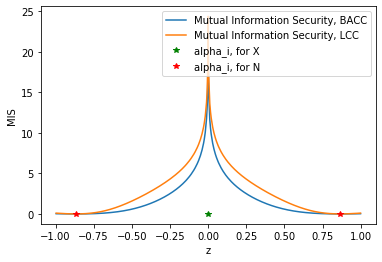

-0.9960065472726245 0.024246284094422223
-0.9945806304055294 0.02379138948912273
-0.993493820294377 0.02344658388246322
-0.9915948270662338 0.02284811569959494
-0.9898654400800284 0.02230760460521098
-0.9897014327908784 0.022256570490235782
-0.988038212984107 0.021741257534331246
-0.9855355914753883 0.020973626381079663
-0.9836359338139788 0.02039727443095157
-0.9833772703799692 0.0203192250498566
-0.9788318268364826 0.018964774051525496
-0.9759626600991576 0.01812685312430741
-0.9747165405337235 0.01776714244762389
-0.9733447938473296 0.0173741628752302
-0.9711924567729937 0.016763972611583335
-0.9674330021665809 0.015717351079513994
-0.9652858824012636 0.015130801675177045
-0.9652457929172171 0.015119928807473135
-0.9642087780812734 0.014839687334542639
-0.9638938590998354 0.014754971483028234
-0.9621416084416963 0.014286926257770411
-0.9599432872341076 0.013707798213239565
-0.9593561339584071 0.01355465651173764
-0.9586057977696858 0.013359906725444062
-0.9575513224099064 0.01308803

-0.21601643520851632 2.936114907964704
-0.21482291810189036 2.952669700116319
-0.2138619533665631 2.9660645131722596
-0.21102352244253209 3.0059761127642646
-0.20869144038840615 3.0391627126063656
-0.20825602812902444 3.0453989380058952
-0.20780185836614273 3.0519173954357286
-0.20194191698088693 3.1372908490862805
-0.20051748488093213 3.158407685309725
-0.19999485756051416 3.1661920921550553
-0.19584463945328867 3.228719489839688
-0.19121690454129636 3.299975417605105
-0.1907532743252467 3.3072060677754025
-0.19039175227583716 3.3128560868763848
-0.1899624246263356 3.319579310327534
-0.18739512473707354 3.360092530780653
-0.18698528972676431 3.3666095921654775
-0.18373507469116102 3.4187881242197378
-0.18113884958256787 3.4611126560919256
-0.17937794199732138 3.490154460430079
-0.1775175647730476 3.521137433791579
-0.1745138247141691 3.571830065883337
-0.17318041639174186 3.5946038161512948
-0.1730496697540147 3.5968459868799765
-0.17061225489905563 3.6389472109770202
-0.1698676542007

In [36]:
K = 1
T = 2
Noise_Alloc = [0,2]
sigma = 1

N = 2

j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T)))

i_array = np.array(range(N))
beta_array = np.cos(i_array*2*math.pi/(N-1)/2) # np.cos(i_array*2*math.pi/N/2)
# print("z_array: ",z_array,'\n')

N = 1000
z_array = np.random.uniform(-1,1,N) #np.cos(i_array[1:]*2*math.pi/(K+T)/2) # np.cos(i_array*2*math.pi/N/2)
z_array = np.sort(z_array)
MIS_array = np.zeros((N))
MIS_LCC_array = np.zeros((N))
# print(z_array)

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)

B = [0.5, 1, 1.5, 2]

z_array_0 = []
z_array_1 = []
z_array_2 = []
z_array_3 = []
z_array_4 = []

for j in range(len(z_array)):
    MIS_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma)
    MIS_LCC_array[j] = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma, _is_LCC=True)
    
    if MIS_array[j] < B[0]:
        z_array_0.append(z_array[j])
    elif MIS_array[j] < B[1]:
        z_array_1.append(z_array[j])
    elif MIS_array[j] < B[2]:
        z_array_2.append(z_array[j])
    elif MIS_array[j] < B[3]:
        z_array_3.append(z_array[j])
    else:
        z_array_4.append(z_array[j])
#     print('(beta index, MIS) = ',j,',',MIS_array[j])
#     print()



print(len(z_array_0),len(z_array_1),len(z_array_2),len(z_array_3),len(z_array_4))


plt.plot(z_array, MIS_array, label='Mutual Information Security, BACC')
plt.plot(z_array, MIS_LCC_array, label='Mutual Information Security, LCC')
plt.plot(alpha_array[Signal_Alloc],0*np.ones(len(Signal_Alloc)),'g*',label='alpha_i, for X')
plt.plot(alpha_array[Noise_Alloc],0*np.ones(len(Noise_Alloc)),'r*',label='alpha_i, for N')
# plt.plot(beta_array,0*np.ones(len(beta_array)),'b.',label='beta_i')
plt.xlabel('z')
plt.ylabel('MIS')
plt.legend()
plt.show()
    
for i in range(len(z_array)):
    print(z_array[i],MIS_array[i])
    
# print(alpha_array[Signal_Alloc])
# print(alpha_array[Noise_Alloc])
# print(alpha_array)

# plt.plot((2*j_array[Signal_Alloc]+1)/(K+T),alpha_array[Signal_Alloc],'g*',label='alpha_i, for X')
# plt.plot((2*j_array[Noise_Alloc]+1)/(K+T),alpha_array[Noise_Alloc],'r*',label='alpha_i, for N')
# plt.plot(2*i_array[1:]/(K+T), z_array,'b.',label='beta_i')
# plt.legend()
# plt.show()

In [50]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 4

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 2
sigma = 1
Noise_Alloc = [0,2]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.521, 0.521])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K4_G4_N8 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G4_N8  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G4_N8[trial_idx][iter] = acc_test
        loss_test_arr_K4_G4_N8[trial_idx][iter] = loss_test

        
        
    

2 1 2
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 958/10000 (9.58%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3025 
Accuracy: 794/10000 (7.94%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 974/10000 (9.74%)

selected users: [0 1]


In [29]:
acc_test_arr_K4_G2_N4 = acc_test_arr_G2

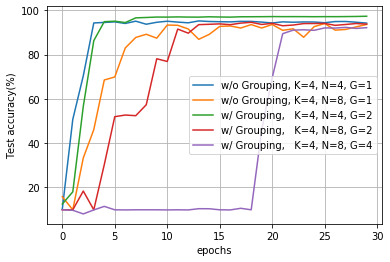

In [58]:
B_sel = 0

# plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K4_G1[2,B_sel,0,0:30],label='w/o Grouping, K=4, N=4, G=1' )
plt.plot(acc_test_arr_K4_G1[3,B_sel,0,0:30],label='w/o Grouping, K=4, N=8, G=1' )
# plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K4_G2_N4[0,0:30],label='w/ Grouping,   K=4, N=4, G=2')
plt.plot(acc_test_arr_K4_G2_N8[0,0:30],label='w/ Grouping,   K=4, N=8, G=2')
plt.plot(acc_test_arr_K4_G4_N8[0,0:30],label='w/ Grouping,   K=4, N=8, G=4')
# plt.plot(acc_test_arr_G3[0,0:30],label='Grouping, N=6, G=3, B='+str(B_array[B_sel]))

# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 5. Without model encoding

In [44]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 5
sigma = 1
Noise_Alloc = [0,2,4,6,8]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [8]
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_K4_G1_v2 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K4_G1_v2  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)

        if N==2:
            z_array = np.array([-0.81, 0.81])
        elif N ==4:
            z_array = np.array([-0.81, -0.22, 0.22, 0.81])
        elif N ==5:
            z_array = np.array([-0.81, -0.22, 0, 0.22, 0.81])
        elif N ==6:
            z_array = np.array([-0.9, -0.81, -0.22, 0.22, 0.81, 0.9])
        elif N ==7:
            z_array = np.array([-0.9, -0.82, -0.21, 0, 0.21, 0.82, 0.9])
        else:
            z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
#             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N, K, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1_v2[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1_v2[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [-0.94  -0.73  -0.534 -0.125  0.125  0.534  0.73   0.94 ]
0.4486236179368535
0.49983046821646326
0.48963480280841937
0.4857187736123886
0.48571877361238697
0.4896348028084205
0.4998304682164621
0.4486236179368556
@BACC_Enc: N,K,T, m_i= 8 4 5 15000 

@BACC_Enc: N,K,T, m_i= 8 4 5 15000 

(T, sigma)= 5 1 )  0 -th Trial!!
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.2877 
Accuracy: 3944/10000 (39.44%)

Round   2, Average loss 2.288 Test accuracy 39.440
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 2.0699 
Accuracy: 7961/10000 (79.61%)

Round   3, Average loss 2.070 Test accuracy 79.610
selected users: [0 1 2 3 4 5 6 7]

Test set: Average loss: 1.7928 
Accuracy: 9264

In [45]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

G = 2
N = 4 # N should be divisible by G
K = 4 # N should be divisible by G

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_G2_N4_v2 = np.zeros((N_trials,N_epochs))
acc_test_arr_G2_N4_v2  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

#             coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
#                 w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_G2_N4_v2[trial_idx][iter] = acc_test
        loss_test_arr_G2_N4_v2[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2202 
Accuracy: 4077/10000 (40.77%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.7585 
Accuracy: 8011/10000 (80.11%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.2700 
Accuracy: 9568/10000 (95.68%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.1997 
Accuracy: 9657/10000 (96.57%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.2082 
Accuracy: 9679/10000 (96.79%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.1947 
Accuracy: 9698/10000 (96.98%)

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 0.2030 
Accuracy: 9723/10000 (97.23%)

selected users

In [46]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 2

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, -0.22, 0.22, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K4_G2_N8_v2 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G2_N8_v2  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

#             coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
#                 w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G2_N8_v2[trial_idx][iter] = acc_test
        loss_test_arr_K4_G2_N8_v2[trial_idx][iter] = loss_test

        
        
    

4 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.3025 
Accuracy: 974/10000 (9.74%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.2943 
Accuracy: 2544/10000 (25.44%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 2.0631 
Accuracy: 6656/10000 (66.56%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 1.9568 
Accuracy: 8542/10000 (85.42%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 1.8062 
Accuracy: 9612/10000 (96.12%)

selected users: [0 1 2 3]
selected users: [0 1 2 3]

Test set: Average loss: 1

In [47]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 4

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 2
sigma = 1
Noise_Alloc = [0,2]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.521, 0.521])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K4_G4_N8_v2 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G4_N8_v2  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v3(net_glob.cuda(), N_i, K_i, T, 0.01, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
#                 w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G4_N8_v2[trial_idx][iter] = acc_test
        loss_test_arr_K4_G4_N8_v2[trial_idx][iter] = loss_test

        
        
    

2 1 2
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.2967 
Accuracy: 4766/10000 (47.66%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.9995 
Accuracy: 7548/10000 (75.48%)

selected users: [0 1]
selected users: [0 1]
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.8282 
Accuracy: 9493/10000 (94.93%)

selected users: 

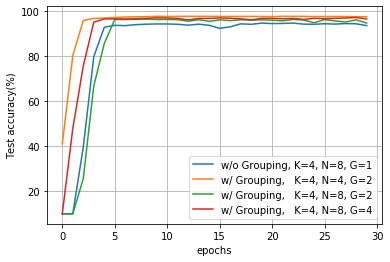

In [49]:
B_sel = 0

# plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K4_G1_v2[0,B_sel,0,0:30],label='w/o Grouping, K=4, N=8, G=1' )
# plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_G2_N4_v2[0,0:30],label='w/ Grouping,   K=4, N=4, G=2')
plt.plot(acc_test_arr_K4_G2_N8_v2[0,0:30],label='w/ Grouping,   K=4, N=8, G=2')
plt.plot(acc_test_arr_K4_G4_N8_v2[0,0:30],label='w/ Grouping,   K=4, N=8, G=4')
# plt.plot(acc_test_arr_G3[0,0:30],label='Grouping, N=6, G=3, B='+str(B_array[B_sel]))

# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 6. Fix the model encoding

In [68]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 5
sigma = 1
Noise_Alloc = [0,2,4,6,8]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [4, 4, 4, 8]
B_array = [0.5]

N_trials = 1
N_epochs = 30



loss_test_arr_K4_G1_v3 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K4_G1_v3  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
        print(N_idx,'!!!')
        if N_idx==0:
            z_array = np.array([-0.94,-0.534,0.534, 0.94])
        elif N_idx==1:
            z_array = np.array([-0.94, -0.73, 0.73, 0.94])
        elif N_idx==2:
            z_array = np.array([-0.94, -0.125, 0.125, 0.94])
        else:
            z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
#             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
            
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNMnist2(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1_v3[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1_v3[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

0 !!!
z_array: [-0.94  -0.534  0.534  0.94 ]
0.4486236179368535
0.48963480280841937
0.4896348028084205
0.4486236179368556
@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

@BACC_Enc: N,K,T, m_i= 4 4 5 15000 

(T, sigma)= 5 1 )  0 -th Trial!!
selected users: [0 1 2 3]
conv1.weight 0.012858290672302247
conv1.bias 0.015318877063691616
conv2.weight 0.0004168525710701942
conv2.bias 0.00041445204988121986
fc1.weight 0.0003280941862612963
fc1.bias 0.0004276319872587919

Test set: Average loss: 2.2418 
Accuracy: 5172/10000 (51.72%)

Round   0, Average loss 2.242 Test accuracy 51.720
selected users: [0 1 2 3]
conv1.weight 0.0006372705101966858
conv1.bias 0.008826728910207748
conv2.weight 0.0009889981895685196
conv2.bias 0.0022288253530859947
fc1.weight 0.0006293328013271093
fc1.bias 0.0011550872586667538

Test set: Average loss: 1.6220 
Accuracy: 5660/10000 (56.60%)

Round   1, Average loss 1.622 Test accuracy 56.600
selected users: [0 1 2 3]
conv1.weight 0.0007359202206134796
conv1.bias 0.01496768463402986


Test set: Average loss: 0.4298 
Accuracy: 9127/10000 (91.27%)

Round  23, Average loss 0.430 Test accuracy 91.270
selected users: [0 1 2 3]
conv1.weight 0.0011326855421066285
conv1.bias 0.020428882911801338
conv2.weight 0.0005401876196265221
conv2.bias 0.0034400380682200193
fc1.weight 0.0009613695554435253
fc1.bias 0.0050285980105400085

Test set: Average loss: 0.4482 
Accuracy: 9109/10000 (91.09%)

Round  24, Average loss 0.448 Test accuracy 91.090
selected users: [0 1 2 3]
conv1.weight 0.0009945099055767058
conv1.bias 0.016359535977244377
conv2.weight 0.000573878027498722
conv2.bias 0.003497322089970112
fc1.weight 0.0009720459580421448
fc1.bias 0.003074977919459343

Test set: Average loss: 0.4101 
Accuracy: 9125/10000 (91.25%)

Round  25, Average loss 0.410 Test accuracy 91.250
selected users: [0 1 2 3]
conv1.weight 0.000986441671848297
conv1.bias 0.01547280140221119
conv2.weight 0.0005771603807806969
conv2.bias 0.0036638746969401836
fc1.weight 0.001145122479647398
fc1.bias 0.004723


Test set: Average loss: 58.6623 
Accuracy: 974/10000 (9.74%)

Round  17, Average loss 58.662 Test accuracy 9.740
selected users: [0 1 2 3]
conv1.weight 0.0034457188844680786
conv1.bias 0.025090564042329788
conv2.weight 0.0012654034793376922
conv2.bias 0.003640583949163556
fc1.weight 0.003008909709751606
fc1.bias 0.0016027364879846572

Test set: Average loss: 29.5323 
Accuracy: 3474/10000 (34.74%)

Round  18, Average loss 29.532 Test accuracy 34.740
selected users: [0 1 2 3]
conv1.weight 0.005907734632492065
conv1.bias 0.04078202694654465
conv2.weight 0.0016320143640041352
conv2.bias 0.007898061536252499
fc1.weight 0.003443567454814911
fc1.bias 0.005083336681127548

Test set: Average loss: 19.7878 
Accuracy: 1005/10000 (10.05%)

Round  19, Average loss 19.788 Test accuracy 10.050
selected users: [0 1 2 3]
conv1.weight 0.003910978436470032
conv1.bias 0.01596067100763321
conv2.weight 0.0013189630210399628
conv2.bias 0.003738993778824806
fc1.weight 0.0023956380784511564
fc1.bias 0.0013460


Test set: Average loss: 0.2267 
Accuracy: 9574/10000 (95.74%)

Round  11, Average loss 0.227 Test accuracy 95.740
selected users: [0 1 2 3]
conv1.weight 0.0016348937153816223
conv1.bias 0.019785067066550255
conv2.weight 0.0005435574054718017
conv2.bias 0.00346518587321043
fc1.weight 0.0009837357327342033
fc1.bias 0.005536499246954918

Test set: Average loss: 0.2983 
Accuracy: 9517/10000 (95.17%)

Round  12, Average loss 0.298 Test accuracy 95.170
selected users: [0 1 2 3]
conv1.weight 0.0014174069464206697
conv1.bias 0.021441340446472168
conv2.weight 0.0005622993409633636
conv2.bias 0.003557561431080103
fc1.weight 0.0010406550019979477
fc1.bias 0.005531302466988563

Test set: Average loss: 0.2739 
Accuracy: 9529/10000 (95.29%)

Round  13, Average loss 0.274 Test accuracy 95.290
selected users: [0 1 2 3]
conv1.weight 0.0012950021028518676
conv1.bias 0.02111590839922428
conv2.weight 0.0006455644965171814
conv2.bias 0.0036865274887531996
fc1.weight 0.0009174076840281487
fc1.bias 0.004364


Test set: Average loss: 2.2952 
Accuracy: 2061/10000 (20.61%)

Round   5, Average loss 2.295 Test accuracy 20.610
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.00036832012236118314
conv1.bias 0.0012810869375243783
conv2.weight 8.617975749075413e-05
conv2.bias 0.0009723107796162367
fc1.weight 0.00023001062218099832
fc1.bias 0.0005224475637078286

Test set: Average loss: 2.3010 
Accuracy: 1853/10000 (18.53%)

Round   6, Average loss 2.301 Test accuracy 18.530
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.00027801811695098876
conv1.bias 0.001669212244451046
conv2.weight 3.4159000497311356e-05
conv2.bias 0.0007447409443557262
fc1.weight 0.00011149424826726318
fc1.bias 0.0004980222787708044

Test set: Average loss: 2.3026 
Accuracy: 974/10000 (9.74%)

Round   7, Average loss 2.303 Test accuracy 9.740
selected users: [0 1 2 3 4 5 6 7]
conv1.weight 0.0001716284640133381
conv1.bias 0.002495931228622794
conv2.weight 0.00010263183154165744
conv2.bias 0.001184726832434535
fc1.weight 0.0002


Test set: Average loss: 2.1309 
Accuracy: 6367/10000 (63.67%)

Round  29, Average loss 2.131 Test accuracy 63.670


In [64]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

G = 2
N = 4 # N should be divisible by G
K = 4 # N should be divisible by G

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_G2_N4_v3 = np.zeros((N_trials,N_epochs))
acc_test_arr_G2_N4_v3  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_G2_N4_v3[trial_idx][iter] = acc_test
        loss_test_arr_G2_N4_v3[trial_idx][iter] = loss_test

        
        
    

2 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

@BACC_Enc: N,K,T, m_i= 2 2 3 15000 

selected users: [0 1]
conv1.weight 0.013846602439880371
conv1.bias 0.01534747239202261
conv2.weight 0.0004163539037108421
conv2.bias 0.000362216989742592
fc1.weight 0.000324129150249064
fc1.bias 0.0003244827501475811
selected users: [0 1]
conv1.weight 0.013846602439880371
conv1.bias 0.01534747239202261
conv2.weight 0.0004163539037108421
conv2.bias 0.000362216989742592
fc1.weight 0.000324129150249064
fc1.bias 0.0003244827501475811

Test set: Average loss: 2.3025 
Accuracy: 1022/10000 (10.22%)

selected users: [0 1]
conv1.weight 0.0028013825416564942
conv1.bias 0.006639664061367512
conv2.weight 0.001011577770113945
conv2.bias 0.0016109333373606205
fc1.weight 0.00031267027370631697
fc1.bias 0.0013865872286260128
selected users: [0 1]
conv1.weight 0.00280138254165

selected users: [0 1]
conv1.weight 0.0018546444177627564
conv1.bias 0.02410038933157921
conv2.weight 0.0006891255080699921
conv2.bias 0.003520965576171875
fc1.weight 0.001382106263190508
fc1.bias 0.006421586126089096

Test set: Average loss: 0.2391 
Accuracy: 9630/10000 (96.30%)

selected users: [0 1]
conv1.weight 0.0019441361725330353
conv1.bias 0.025488246232271194
conv2.weight 0.0006017382815480233
conv2.bias 0.0034130322746932507
fc1.weight 0.001223507523536682
fc1.bias 0.006876526772975922
selected users: [0 1]
conv1.weight 0.0019441361725330353
conv1.bias 0.025488246232271194
conv2.weight 0.0006017382815480233
conv2.bias 0.0034130322746932507
fc1.weight 0.001223507523536682
fc1.bias 0.006876526772975922

Test set: Average loss: 0.2185 
Accuracy: 9661/10000 (96.61%)

selected users: [0 1]
conv1.weight 0.002030629515647888
conv1.bias 0.02344357781112194
conv2.weight 0.0004928788542747498
conv2.bias 0.0030704722739756107
fc1.weight 0.0009367094375193119
fc1.bias 0.005650547891855239

In [65]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 2

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, -0.22, 0.22, 0.81])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K4_G2_N8_v3 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G2_N8_v3  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G2_N8_v3[trial_idx][iter] = acc_test
        loss_test_arr_K4_G2_N8_v3[trial_idx][iter] = loss_test

        
        
    

4 2 3
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

@BACC_Enc: N,K,T, m_i= 4 2 3 15000 

selected users: [0 1 2 3]
conv1.weight 0.012238214015960694
conv1.bias 0.012197405099868774
conv2.weight 0.00041676975786685943
conv2.bias 0.0004572461766656488
fc1.weight 0.0003275977214798331
fc1.bias 0.00024432113859802486
selected users: [0 1 2 3]
conv1.weight 0.012238214015960694
conv1.bias 0.012197405099868774
conv2.weight 0.00041676975786685943
conv2.bias 0.0004572461766656488
fc1.weight 0.0003275977214798331
fc1.bias 0.00024432113859802486

Test set: Average loss: 2.3025 
Accuracy: 1595/10000 (15.95%)

selected users: [0 1 2 3]
conv1.weight 0.00032409843057394026
conv1.bias 0.0013604930136352777
conv2.weight 0.00028322940692305566
conv2.bias 0.0005288161337375641
fc1.weight 6.303526461124421e-05
fc1.bias 0.00033167744986712934
selected users: [0 1 2 3]

selected users: [0 1 2 3]
conv1.weight 0.0004403708875179291
conv1.bias 0.0010100736981257796
conv2.weight 0.00016050683334469795
conv2.bias 0.0007882289355620742
fc1.weight 0.00020547243766486645
fc1.bias 0.0006706926971673966

Test set: Average loss: 2.2047 
Accuracy: 6005/10000 (60.05%)

selected users: [0 1 2 3]
conv1.weight 0.0003312908858060837
conv1.bias 0.0010048537515103817
conv2.weight 0.00017637999728322028
conv2.bias 0.0008865775307640433
fc1.weight 9.666537516750395e-05
fc1.bias 0.000818482879549265
selected users: [0 1 2 3]
conv1.weight 0.0003312908858060837
conv1.bias 0.0010048537515103817
conv2.weight 0.00017637999728322028
conv2.bias 0.0008865775307640433
fc1.weight 9.666537516750395e-05
fc1.bias 0.000818482879549265

Test set: Average loss: 2.2191 
Accuracy: 3909/10000 (39.09%)

selected users: [0 1 2 3]
conv1.weight 0.00034947231411933897
conv1.bias 0.0019296954851597548
conv2.weight 3.93584044650197e-05
conv2.bias 0.0006756547372788191
fc1.weight 0.00022974447347223

In [66]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 8
K = 4
G = 4

size_per_group = int(60000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,28*28))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 


N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 2
sigma = 1
Noise_Alloc = [0,2]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.521, 0.521])

B = 0.5

N_trials = 1
N_epochs = 30

loss_test_arr_K4_G4_N8_v3 = np.zeros((N_trials,N_epochs))
acc_test_arr_K4_G4_N8_v3  = np.zeros((N_trials,N_epochs))

for trial_idx in range(N_trials):
    
    print('##########################################')
    print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNMnist2(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,28*28))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G4_N8_v3[trial_idx][iter] = acc_test
        loss_test_arr_K4_G4_N8_v3[trial_idx][iter] = loss_test

        
        
    

2 1 2
##########################################
###### 0 -th Trial!! ###########
@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

@BACC_Enc: N,K,T, m_i= 2 1 2 15000 

selected users: [0 1]
conv1.weight 0.013706564903259277
conv1.bias 0.011211898177862167
conv2.weight 0.0004167964681982994
conv2.bias 0.0004621360276360065
fc1.weight 0.0003252577967941761
fc1.bias 0.00027899821288883685
selected users: [0 1]
conv1.weight 0.013706564903259277
conv1.bias 0.011211898177862167
conv2.weight 0.0004167964681982994
conv2.bias 0.0004621360276360065
fc1.weight 0.0003252577967941761
fc1.bias 0.00027899821288883685
selected users: [0 1]
conv1.weight 0.013706564903259277
conv1.bias 0.011211898177862167
conv2.weight 0.0004167964681982994
conv2.bias 0.0004621360276360065
fc1.weight 0.00032525779

selected users: [0 1]
conv1.weight 0.00040762938559055326
conv1.bias 0.0028022630140185356
conv2.weight 5.303455051034689e-05
conv2.bias 0.0007048744009807706
fc1.weight 0.00016356507549062372
fc1.bias 0.0006015048362314701
selected users: [0 1]
conv1.weight 0.00040762938559055326
conv1.bias 0.0028022630140185356
conv2.weight 5.303455051034689e-05
conv2.bias 0.0007048744009807706
fc1.weight 0.00016356507549062372
fc1.bias 0.0006015048362314701
selected users: [0 1]
conv1.weight 0.00040762938559055326
conv1.bias 0.0028022630140185356
conv2.weight 5.303455051034689e-05
conv2.bias 0.0007048744009807706
fc1.weight 0.00016356507549062372
fc1.bias 0.0006015048362314701

Test set: Average loss: 2.0002 
Accuracy: 8161/10000 (81.61%)

selected users: [0 1]
conv1.weight 0.00033715613186359407
conv1.bias 0.004703369922935963
conv2.weight 5.9067700058221816e-05
conv2.bias 0.000669245608150959
fc1.weight 0.00020826351828873158
fc1.bias 0.0011112980544567108
selected users: [0 1]
conv1.weight 0.0003


Test set: Average loss: 1.9422 
Accuracy: 8970/10000 (89.70%)

selected users: [0 1]
conv1.weight 0.0004333682730793953
conv1.bias 0.0034522288478910923
conv2.weight 8.975024335086345e-05
conv2.bias 0.0007489094277843833
fc1.weight 0.0002597528975456953
fc1.bias 0.000991189107298851
selected users: [0 1]
conv1.weight 0.0004333682730793953
conv1.bias 0.0034522288478910923
conv2.weight 8.975024335086345e-05
conv2.bias 0.0007489094277843833
fc1.weight 0.0002597528975456953
fc1.bias 0.000991189107298851
selected users: [0 1]
conv1.weight 0.0004333682730793953
conv1.bias 0.0034522288478910923
conv2.weight 8.975024335086345e-05
conv2.bias 0.0007489094277843833
fc1.weight 0.0002597528975456953
fc1.bias 0.000991189107298851
selected users: [0 1]
conv1.weight 0.0004333682730793953
conv1.bias 0.0034522288478910923
conv2.weight 8.975024335086345e-05
conv2.bias 0.0007489094277843833
fc1.weight 0.0002597528975456953
fc1.bias 0.000991189107298851

Test set: Average loss: 1.8916 
Accuracy: 8631/1000

selected users: [0 1]
conv1.weight 0.00029945600777864456
conv1.bias 0.003218692960217595
conv2.weight 0.00012535521760582925
conv2.bias 0.0011503624264150858
fc1.weight 0.00019295464735478163
fc1.bias 0.0007758977822959423

Test set: Average loss: 1.8970 
Accuracy: 8594/10000 (85.94%)

selected users: [0 1]
conv1.weight 0.0004805023968219757
conv1.bias 0.004676062613725662
conv2.weight 8.430168963968754e-05
conv2.bias 0.0009683126118034124
fc1.weight 0.00020473995245993138
fc1.bias 0.0012194647453725338
selected users: [0 1]
conv1.weight 0.0004805023968219757
conv1.bias 0.004676062613725662
conv2.weight 8.430168963968754e-05
conv2.bias 0.0009683126118034124
fc1.weight 0.00020473995245993138
fc1.bias 0.0012194647453725338
selected users: [0 1]
conv1.weight 0.0004805023968219757
conv1.bias 0.004676062613725662
conv2.weight 8.430168963968754e-05
conv2.bias 0.0009683126118034124
fc1.weight 0.00020473995245993138
fc1.bias 0.0012194647453725338
selected users: [0 1]
conv1.weight 0.000480502

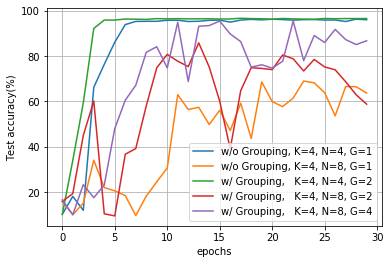

In [69]:
B_sel = 0

# plt.plot(acc_test_arr_v1[0,B_sel,0,0:30],label='N=2, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_K4_G1_v3[2,B_sel,0,0:30],label='w/o Grouping, K=4, N=4, G=1' )
plt.plot(acc_test_arr_K4_G1_v3[3,B_sel,0,0:30],label='w/o Grouping, K=4, N=8, G=1' )
# plt.plot(acc_test_arr_v1[2,B_sel,0,0:30],label='N=6, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[3,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))
plt.plot(acc_test_arr_G2_N4_v3[0,0:30],label='w/ Grouping,   K=4, N=4, G=2')
plt.plot(acc_test_arr_K4_G2_N8_v3[0,0:30],label='w/ Grouping,   K=4, N=8, G=2')
plt.plot(acc_test_arr_K4_G4_N8_v3[0,0:30],label='w/ Grouping,   K=4, N=8, G=4')
# plt.plot(acc_test_arr_G3[0,0:30],label='Grouping, N=6, G=3, B='+str(B_array[B_sel]))

# plt.plot(acc_test_arr_v1[4,B_sel,0,0:30],label='N=7, B='+str(B_array[B_sel]))
# plt.plot(acc_test_arr_v1[5,B_sel,0,0:30],label='N=8, B='+str(B_array[B_sel]))

# plt.plot(plot_acc_v2[2,sigma_sel,:],label='T=10')
# plt.plot(plot_acc_v2[3,sigma_sel,:],label='T=11')

# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()